## Step 2: Attemt to build model on grayscale images using SeparableConv2D and GlobalAveragePooling2D

About SeparableConv2D: https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
About GlobalAveragePooling2D: 
- https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras
- https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/

In [105]:
import os
import pathlib
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications, models
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV3Small
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import mixed_precision

os.environ["CUDA_VISIBLE_DEVICES"]="-1"    


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [106]:
# constants

SEED = 7000
image_size = (256, 256)
image_shape = image_size + (3,)

BATCH_SIZE = 32

path = "./data/crop/"
data_dir = pathlib.Path(path)

In [107]:
# Splitting full dataset to testing and training

print('Train data')
train_df = image_dataset_from_directory(data_dir,
                                          validation_split=0.3,
                                          subset='training',
                                          seed=SEED,
                                          shuffle=True,
                                          image_size=image_size,
                                          interpolation='bilinear',
                                          color_mode='rgb',
                                          batch_size=BATCH_SIZE
                                          )
train_df
print('\nValidation data')
validation_df = image_dataset_from_directory(data_dir,
                                               validation_split=0.3,
                                               subset='validation',
                                               shuffle = True,       
                                               seed=SEED,
                                               image_size=image_size,
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE)

validation_df

print('\nTraining dataset: ' + str(train_df))
print('There is {} images in the training dataset'.format(len(train_df)))
print('Validation dataset: ' + str(validation_df))
print('There is {} images in the validation dataset'.format(len(validation_df)))

Train data
Found 27564 files belonging to 60 classes.
Using 19295 files for training.

Validation data
Found 27564 files belonging to 60 classes.
Using 8269 files for validation.

Training dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
There is 603 images in the training dataset
Validation dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
There is 259 images in the validation dataset


In [109]:
class_names = train_df.class_names

def plot_images_from_df(ds, class_names):
    plt.figure(figsize = (20, 20))
    for images, labels in ds.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]] + " " + str(images[i].shape))

## Pre-Process data

In [110]:
def preprocess_image(image, label):
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    
    # # Normalize pixel values to range 0-1
    # # image = image / 255.0  # Original normalization
    # image = tf.image.per_image_standardization(image)  # Alternative normalization
    
    # # # Clip the pixel values to avoid extreme values after standardization
    # image = tf.clip_by_value(image, 0.0, 1.0)
    
    # # # Enhance contrast
    # image = tf.image.adjust_contrast(image, 3.0)

    # IT WAS WORST DECISION IN THIS LAB
    # Apply edge enhancement 
    # edge_kernel = tf.constant([[-1, -1, -1], 
    #                            [-1,  9, -1], 
    #                            [-1, -1, -1]], dtype=tf.float32)
    # edge_kernel = tf.reshape(edge_kernel, [3, 3, 1, 1])
    # image = tf.nn.conv2d(tf.expand_dims(image, 0), edge_kernel, strides=[1,1,1,1], padding='SAME')
    # image = tf.squeeze(image, 0)
    
    return image, label


# Moved to the model section

# def apply_data_augmentation(image, label):
#     # Random rotation
#     image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

#     # Random flip
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    
#     # Random brightness
#     image = tf.image.random_brightness(image, max_delta=0.1)
    
#     # Random contrast
#     image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
#     # Ensure the image values are still in the valid range
#     image = tf.clip_by_value(image, 0.0, 1.0)
    
#     # Ensure the output is in float32 format
#     image = tf.cast(image, tf.float32)
    
#     return image, label

In [111]:
# prefetch() function is used to produce a dataset that prefetches the specified elements from this given dataset. 
# It accepts a bufferSize parameter. 
# It is an integer value that specifies the number of elements to be prefetched

# Apply preprocessing and augmentation for the traing data
train_ds = train_df.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# # Apply ONLY preprocessing for the validation data
validation_ds = validation_df.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

2024-08-05 13:07:16.268610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19295]
	 [[{{node Placeholder/_0}}]]
2024-08-05 13:07:16.269175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [19295]
	 [[{{node Placeholder/_4}}]]


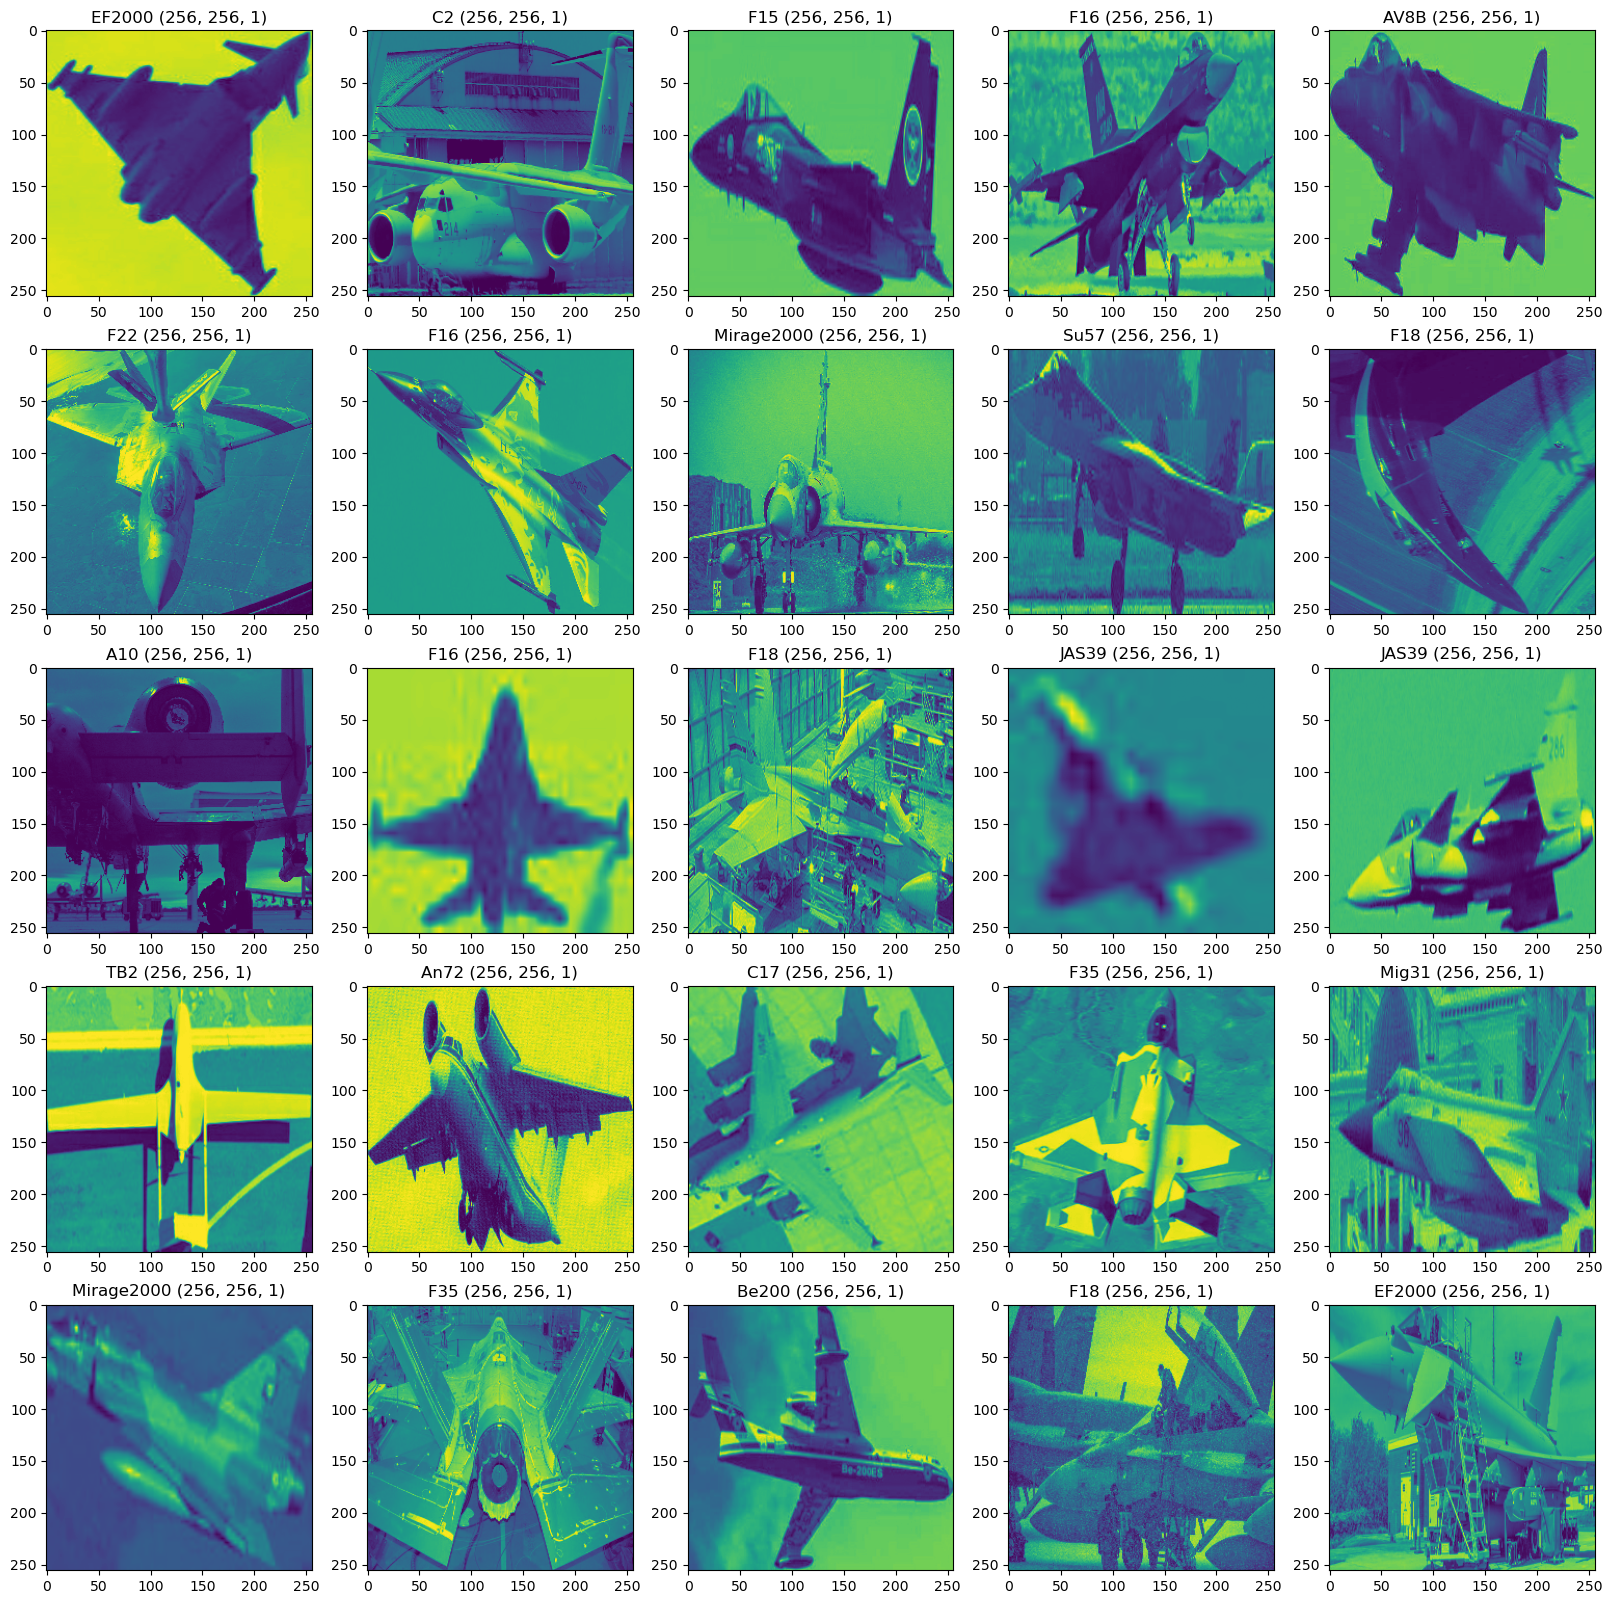

In [112]:
plot_images_from_df(train_ds, class_names)

In [118]:
class_names = train_df.class_names

num_classes = len(class_names)

def create_lightweight_model():
    # Have no idea why but it breack my kernel
    # data_augmentation = tf.keras.Sequential([
    #     layers.RandomFlip("horizontal"),
    #     layers.RandomRotation(0.1),
    #     layers.RandomZoom(0.1),
    # ])
    
    model = models.Sequential([
        layers.Input(shape=(256, 256, 1)),
        # data_augmentation,
        layers.SeparableConv2D(8, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(16, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0025)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(48, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
        layers.BatchNormalization(epsilon= 0.01),
        layers.MaxPooling2D(),
        # layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(epsilon= 0.01),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.25),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_lightweight_model()


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_97 (Separa  (None, 254, 254, 8)      25        
 bleConv2D)                                                      
                                                                 
 batch_normalization_133 (Ba  (None, 254, 254, 8)      32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 127, 127, 8)      0         
 ng2D)                                                           
                                                                 
 separable_conv2d_98 (Separa  (None, 125, 125, 16)     216       
 bleConv2D)                                                      
                                                                 
 batch_normalization_134 (Ba  (None, 125, 125, 16)   

In [119]:
# Configure for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# Learning rate schedule
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [120]:
# Train the model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50


2024-08-05 13:09:10.339474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [19295]
	 [[{{node Placeholder/_4}}]]
2024-08-05 13:09:10.339947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [19295]
	 [[{{node Placeholder/_4}}]]
2024-08-05 13:09:20.816972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 213 of 1000
2024-08-05 13:09:30.767700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 430 of 1000


  1/603 [..............................] - ETA: 4:43:08 - loss: 5.1057 - accuracy: 0.0000e+00

2024-08-05 13:09:38.372349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


603/603 [==============================] - ETA: 0s - loss: 4.2038 - accuracy: 0.0597

2024-08-05 13:11:00.077305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8269]
	 [[{{node Placeholder/_0}}]]
2024-08-05 13:11:00.077545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8269]
	 [[{{node Placeholder/_0}}]]
2024-08-05 13:11:10.198042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 203 of 1000
2024-08-05 13:11:12.105174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


603/603 [==============================] - 133s 174ms/step - loss: 4.2038 - accuracy: 0.0597 - val_loss: 3.9207 - val_accuracy: 0.0773 - lr: 0.0010
Epoch 2/50
603/603 [==============================] - 95s 157ms/step - loss: 3.8288 - accuracy: 0.0795 - val_loss: 3.7485 - val_accuracy: 0.0865 - lr: 0.0010
Epoch 3/50
603/603 [==============================] - 95s 157ms/step - loss: 3.7094 - accuracy: 0.0949 - val_loss: 3.6703 - val_accuracy: 0.0981 - lr: 0.0010
Epoch 4/50
603/603 [==============================] - 93s 154ms/step - loss: 3.6364 - accuracy: 0.1079 - val_loss: 3.6250 - val_accuracy: 0.1074 - lr: 0.0010
Epoch 5/50
603/603 [==============================] - 92s 152ms/step - loss: 3.5711 - accuracy: 0.1233 - val_loss: 3.5868 - val_accuracy: 0.1154 - lr: 0.0010
Epoch 6/50
603/603 [==============================] - 97s 161ms/step - loss: 3.5103 - accuracy: 0.1335 - val_loss: 3.4952 - val_accuracy: 0.1396 - lr: 0.0010
Epoch 7/50
603/603 [==============================] - 94s 156m

In [124]:
# persist model
model.save_weights('./custom_model_weights.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_ds)
print(f"Test accuracy: {test_accuracy:.2f}")

259/259 [==============================] - 11s 41ms/step - loss: 3.0928 - accuracy: 0.2468
Test accuracy: 0.25


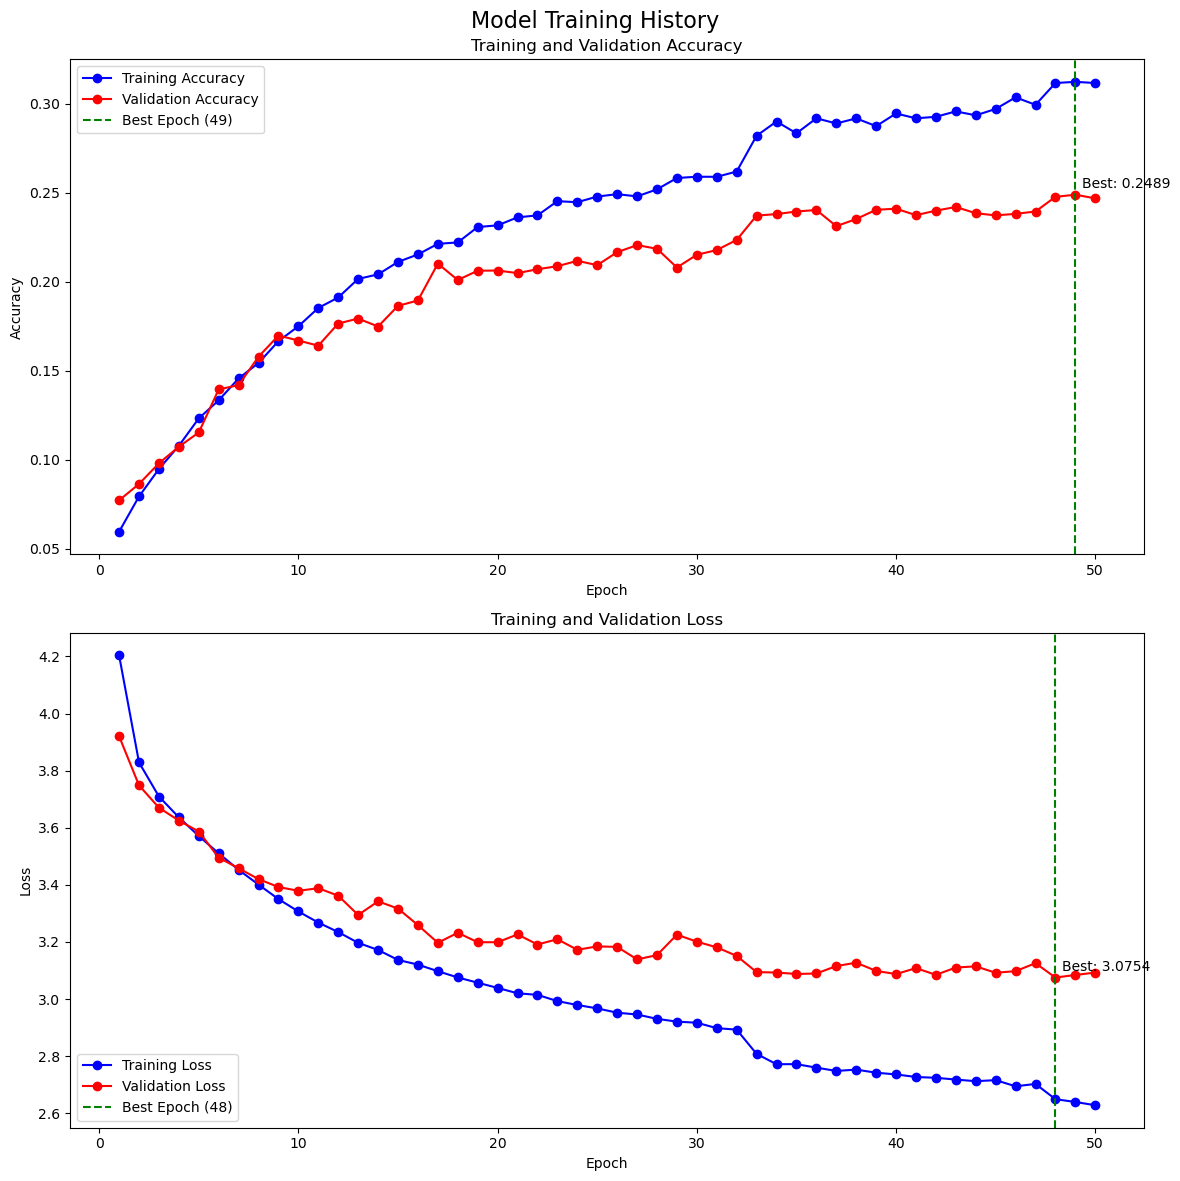

Best Validation Accuracy: 0.2489 at epoch 49
Best Validation Loss: 3.0754 at epoch 48


In [125]:
def plot_training_history(history):
    # Extract history data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Find best epochs
    best_acc_epoch = val_acc.index(max(val_acc)) + 1
    best_loss_epoch = val_loss.index(min(val_loss)) + 1

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle('Model Training History', fontsize=16)

    # Plot accuracy
    ax1.plot(epochs, acc, 'bo-', label='Training Accuracy')
    ax1.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax1.axvline(x=best_acc_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_acc_epoch})')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Add text annotation for best accuracy
    best_val_acc = max(val_acc)
    ax1.annotate(f'Best: {best_val_acc:.4f}', 
                 xy=(best_acc_epoch, best_val_acc),
                 xytext=(5, 5), textcoords='offset points')

    # Plot loss
    ax2.plot(epochs, loss, 'bo-', label='Training Loss')
    ax2.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    ax2.axvline(x=best_loss_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_loss_epoch})')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Add text annotation for best loss
    best_val_loss = min(val_loss)
    ax2.annotate(f'Best: {best_val_loss:.4f}', 
                 xy=(best_loss_epoch, best_val_loss),
                 xytext=(5, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_acc_epoch}")
    print(f"Best Validation Loss: {best_val_loss:.4f} at epoch {best_loss_epoch}")

plot_training_history(history)